# Implementing PMFs

This notebook outlines the API for `Pmf` objects in the `empiricaldist` library, showing the implementations of many methods.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/empiricaldist/blob/master/empiricaldist/pmf_demo.ipynb).

In [ ]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import inspect

def psource(obj):
    """Prints the source code for a given object.

    obj: function or method object
    """
    print(inspect.getsource(obj))

## Constructor

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/1).

The `Pmf` class inherits its constructor from `pd.Series`.

You can create an empty `Pmf` and then add elements.

Here's a `Pmf` that represents a six-sided die.

In [3]:
from empiricaldist import Pmf

d6 = Pmf()

In [4]:
for x in [1,2,3,4,5,6]:
    d6[x] = 1

Initially the probabilities don't add up to 1.

In [5]:
d6

,probs
1,1
2,1
3,1
4,1
5,1
6,1


`normalize` adds up the probabilities and divides through.  The return value is the total probability before normalizing.

In [6]:
psource(Pmf.normalize)

    def normalize(self):
        """Make the probabilities add up to 1 (modifies self).

        Returns: normalizing constant
        """
        total = self.sum()
        self /= total
        return total



In [7]:
d6.normalize()

6

Now the Pmf is normalized.

In [8]:
d6

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


###Properties

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/2).

In a `Pmf` the index contains the quantities (`qs`) and the values contain the probabilities (`ps`).

These attributes are available as properties that return arrays (same semantics as the Pandas `values` property)

In [9]:
d6.qs

array([1, 2, 3, 4, 5, 6])

In [10]:
d6.ps

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

## Sharing

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/3).

Because `Pmf` is a `Series` you can initialize it with any type `Series.__init__` can handle.

Here's an example with a dictionary.

In [11]:
d = dict(a=1, b=2, c=3)
pmf = Pmf(d)
pmf

,probs
a,1
b,2
c,3


Here's an example with two lists.

In [12]:
qs = [1,2,3,4]
ps = [0.25, 0.25, 0.25, 0.25]
d4 = Pmf(ps, index=qs)
d4

,probs
1,0.25
2,0.25
3,0.25
4,0.25


You can copy a `Pmf` like this.

In [13]:
d6_copy = Pmf(d6)
d6_copy

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


However, you have to be careful about sharing.  In this example, the copies share the arrays:

In [14]:
d6.index is d6_copy.index

True

In [15]:
d6.ps is d6_copy.ps

True

You can avoid sharing with `copy=True`

In [16]:
d6_copy = Pmf(d6, copy=True)
d6_copy

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


In [17]:
d6.index is d6_copy.index

True

In [18]:
d6.ps is d6_copy.ps

False

Or by calling `copy` explicitly.

In [19]:
d4_copy = d4.copy()
d4_copy

,probs
1,0.25
2,0.25
3,0.25
4,0.25


In [20]:
d4.index is d4_copy.index

True

In [21]:
d4.ps is d4_copy.ps

False

## Displaying PMFs

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/4).

`Pmf` provides `_repr_html_`, so it looks good when displayed in a notebook.

In [22]:
psource(Pmf._repr_html_)

    def _repr_html_(self):
        """Returns an HTML representation of the series.

        Mostly used for Jupyter notebooks.
        """
        df = pd.DataFrame(dict(probs=self))
        return df._repr_html_()



`Pmf` provides `bar`, which plots the Pmf as a bar chart.

In [23]:
psource(Pmf.bar)

    def bar(self, **options):
        """Make a bar plot.

        Note: A previous version of this function used pd.Series.plot.bar,
        but that was a mistake, because that function treats the quantities
        as categorical, even if they are numerical, leading to hilariously
        unexpected results!

        Args:
        options: passed to plt.bar
        """
        underride(options, label=self.name)
        plt.bar(self.qs, self.ps, **options)



In [24]:
def decorate_dice(title):
    """Labels the axes.
    
    title: string
    """
    plt.xlabel('Outcome')
    plt.ylabel('PMF')
    plt.title(title)

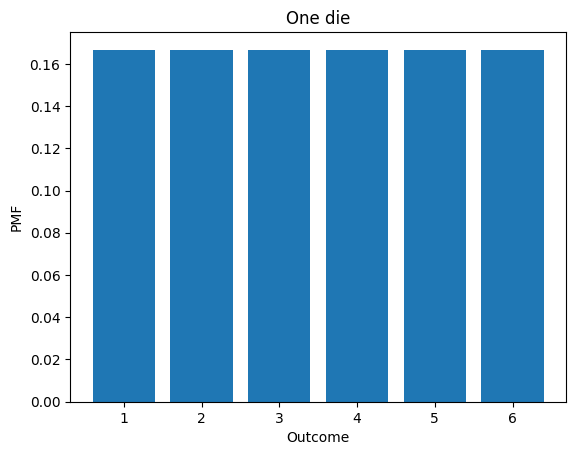

In [25]:
d6.bar()
decorate_dice('One die')

`Pmf` inherits `plot` from `Series`.

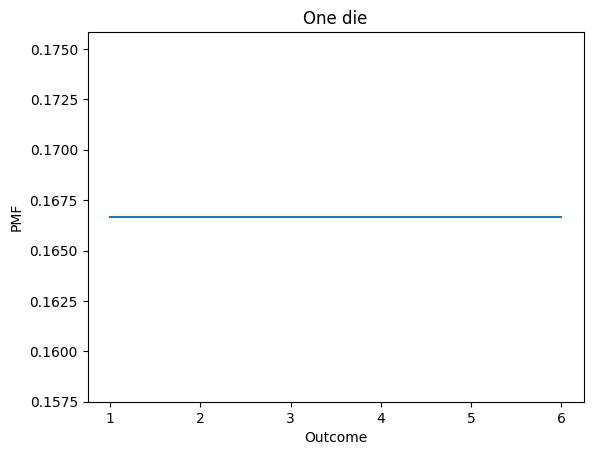

In [26]:
d6.plot()
decorate_dice('One die')

## Make Pmf from sequence

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/5).


The following function makes a `Pmf` object from a sequence of values.

In [27]:
psource(Pmf.from_seq)

    @staticmethod
    def from_seq(
        seq,
        normalize=True,
        sort=True,
        ascending=True,
        dropna=True,
        na_position="last",
        **options,
    ):
        """Make a PMF from a sequence of values.

        Args:
        seq: iterable
        normalize: whether to normalize the Pmf, default True
        sort: whether to sort the Pmf by values, default True
        ascending: whether to sort in ascending order, default True
        dropna: whether to drop NaN values, default True
        na_position: If ‘first’ puts NaNs at the beginning,
                        ‘last’ puts NaNs at the end.
        options: passed to the pd.Series constructor

        Returns: Pmf object
        """
        # compute the value counts
        series = pd.Series(seq).value_counts(
            normalize=normalize, sort=False, dropna=dropna
        )
        # make the result a Pmf
        # (since we just made a fresh Series, there is no reason to copy it)
        

In [28]:
pmf = Pmf.from_seq(list('allen'))
pmf

,probs
a,0.2
e,0.2
l,0.4
n,0.2


In [29]:
pmf = Pmf.from_seq(np.array([1, 2, 2, 3, 5]))
pmf

,probs
1,0.2
2,0.4
3,0.2
5,0.2


## Selection

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/6).

`Pmf` overrides `__getitem__` to return 0 for values that are not in the distribution.

In [30]:
psource(Pmf.__getitem__)

    def __getitem__(self, key):
        check_dict_or_set_indexers(key)
        key = com.apply_if_callable(key, self)

        if key is Ellipsis:
            return self

        key_is_scalar = is_scalar(key)
        if isinstance(key, (list, tuple)):
            key = unpack_1tuple(key)

        if is_integer(key) and self.index._should_fallback_to_positional:
            warnings.warn(
                # GH#50617
                "Series.__getitem__ treating keys as positions is deprecated. "
                "In a future version, integer keys will always be treated "
                "as labels (consistent with DataFrame behavior). To access "
                "a value by position, use `ser.iloc[pos]`",
                FutureWarning,
                stacklevel=find_stack_level(),
            )
            return self._values[key]

        elif key_is_scalar:
            return self._get_value(key)

        # Convert generator to list before going through hashable part
        # (We wi

In [31]:
d6[1]

0.16666666666666666

In [32]:
d6[6]

0.16666666666666666

If you use square brackets to look up a quantity that's not in the `Pmf`, you get a `KeyError`. 

In [33]:
# d6[7]

`Pmf` objects are mutable, but in general the result is not normalized.

In [34]:
d7 = d6.copy()

In [35]:
d7[7] = 1/6
d7

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667
7,0.166667


In [36]:
d7.sum()

1.1666666666666665

In [37]:
d7.normalize()

1.1666666666666665

In [38]:
d7.sum()

1.0000000000000002

## Statistics

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/7).

`Pmf` overrides the statistics methods to compute `mean`, `median`, etc.

These functions only work correctly if the `Pmf` is normalized.

In [39]:
psource(Pmf.mean)

    def mean(self):
        """Computes expected value.

        Returns: float
        """
        if not np.allclose(1, self.sum()):
            raise ValueError("Pmf must be normalized before computing mean")

        if not pd.api.types.is_numeric_dtype(self.dtype):
            raise ValueError("mean is only defined for numeric data")

        return np.sum(self.ps * self.qs)



In [40]:
d6.mean()

3.5

In [41]:
psource(Pmf.var)

    def var(self):
        """Variance of a PMF.

        Returns: float
        """
        m = self.mean()
        d = self.qs - m
        return np.sum(d**2 * self.ps)



In [42]:
d6.var()

2.9166666666666665

In [43]:
psource(Pmf.std)

    def std(self):
        """Standard deviation of a PMF.

        Returns: float
        """
        return np.sqrt(self.var())



In [44]:
d6.std()

1.707825127659933

## Sampling

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/8).

`choice` chooses a random values from the Pmf, following the API of `np.random.choice`

In [45]:
psource(Pmf.choice)

    def choice(self, *args, **kwargs):
        """Makes a random sample.

        Uses the probabilities as weights unless `p` is provided.

        Args:
        args: same as np.random.choice
        kwargs: same as np.random.choice

        Returns: NumPy array
        """
        underride(kwargs, p=self.ps)
        return np.random.choice(self.qs, *args, **kwargs)



In [46]:
d6.choice(size=10)

array([3, 3, 5, 6, 1, 5, 3, 6, 6, 1])

`sample` chooses a random values from the `Pmf`, following the API of `pd.Series.sample`

In [47]:
psource(Pmf.sample)

    def sample(self, *args, **kwargs):
        """Samples with replacement using probabilities as weights.

        Uses the inverse CDF.

        Args:
        n: number of values

        Returns: NumPy array
        """
        cdf = self.make_cdf()
        return cdf.sample(*args, **kwargs)



In [48]:
d6.sample(n=10)

array([3., 3., 5., 1., 1., 1., 3., 5., 3., 6.])

## Arithmetic

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/9).

`Pmf` provides `add_dist`, which computes the distribution of the sum.

The implementation uses outer products to compute the convolution of the two distributions.

In [49]:
psource(Pmf.add_dist)

    def add_dist(self, x):
        """Computes the Pmf of the sum of values drawn from self and x.

        Args:
        x: Distribution, scalar, or sequence

        Returns: new Pmf
        """
        if isinstance(x, Distribution):
            return self.convolve_dist(x, np.add.outer)
        else:
            return Pmf(self.ps.copy(), index=self.qs + x)



In [50]:
psource(Pmf.convolve_dist)

    def convolve_dist(self, dist, ufunc):
        """Convolve two distributions.

        Args:
        dist: Distribution
        ufunc: elementwise function for arrays

        Returns: new Pmf
        """
        dist = dist.make_pmf()
        qs = ufunc(self.qs, dist.qs).flatten()
        ps = np.multiply.outer(self.ps, dist.ps).flatten()
        series = pd.Series(ps).groupby(qs).sum()

        return Pmf(series)



Here's the distribution of the sum of two dice.

In [51]:
d6 = Pmf.from_seq([1,2,3,4,5,6])

twice = d6.add_dist(d6)
twice

,probs
2,0.027778
3,0.055556
4,0.083333
5,0.111111
6,0.138889
7,0.166667
8,0.138889
9,0.111111
10,0.083333
11,0.055556


6.999999999999998

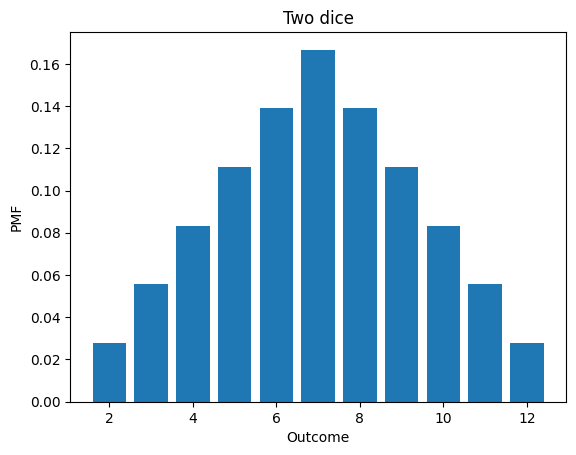

In [52]:
twice.bar()
decorate_dice('Two dice')
twice.mean()

To add a constant to a distribution, you could construct a deterministic `Pmf`

In [53]:
const = Pmf.from_seq([1])
d4.add_dist(const)

,probs
2,0.25
3,0.25
4,0.25
5,0.25


But `add_dist` also handles constants as a special case:

In [54]:
d4.add_dist(1)

,probs
2,0.25
3,0.25
4,0.25
5,0.25


Other arithmetic operations are also implemented

In [55]:
d6.sub_dist(d4)

,probs
-3,0.041667
-2,0.083333
-1,0.125000
0,0.166667
1,0.166667
2,0.166667
3,0.125000
4,0.083333
5,0.041667


In [56]:
d4.mul_dist(d4)

,probs
1,0.0625
2,0.1250
3,0.1250
4,0.1875
6,0.1250
8,0.1250
9,0.0625
12,0.1250
16,0.0625


In [57]:
d4.div_dist(d4)

,probs
0.250000,0.0625
0.333333,0.0625
0.500000,0.1250
0.666667,0.0625
0.750000,0.0625
1.000000,0.2500
1.333333,0.0625
1.500000,0.0625
2.000000,0.1250
3.000000,0.0625


## Comparison operators

`Pmf` implements comparison operators that return probabilities.

You can compare a `Pmf` to a scalar:

In [58]:
d6.lt_dist(3)

0.3333333333333333

In [59]:
d4.ge_dist(2)

0.75

Or compare `Pmf` objects:

In [60]:
d4.gt_dist(d6)

0.25

In [61]:
d6.le_dist(d4)

0.41666666666666663

In [62]:
d4.eq_dist(d6)

0.16666666666666666

Interestingly, this way of comparing distributions is [nontransitive]().

In [63]:
A = Pmf.from_seq([2, 2, 4, 4, 9, 9])
B = Pmf.from_seq([1, 1, 6, 6, 8, 8])
C = Pmf.from_seq([3, 3, 5, 5, 7, 7])

In [64]:
A.gt_dist(B)

0.5555555555555556

In [65]:
B.gt_dist(C)

0.5555555555555556

In [66]:
C.gt_dist(A)

0.5555555555555556

### Joint distributions

For comments or questions about this section, see [this issue](https://github.com/AllenDowney/EmpyricalDistributions/issues/10).

`Pmf.make_joint` takes two `Pmf` objects and makes their joint distribution, assuming independence.

In [67]:
psource(Pmf.make_joint)

    def make_joint(self, other, **options):
        """Make joint distribution (assuming independence).

        Args:
        other: Pmf
        options: passed to Pmf constructor

        Returns: new Pmf
        """
        qs = pd.MultiIndex.from_product([self.qs, other.qs])
        ps = np.multiply.outer(self.ps, other.ps).flatten()
        return Pmf(ps, index=qs, **options)



In [68]:
d4 = Pmf.from_seq(range(1,5))
d4

,probs
1,0.25
2,0.25
3,0.25
4,0.25


In [69]:
d6 = Pmf.from_seq(range(1,7))
d6

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


In [70]:
joint = Pmf.make_joint(d4, d6)
joint

1  1    0.041667
   2    0.041667
   3    0.041667
   4    0.041667
   5    0.041667
   6    0.041667
2  1    0.041667
   2    0.041667
   3    0.041667
   4    0.041667
   5    0.041667
   6    0.041667
3  1    0.041667
   2    0.041667
   3    0.041667
   4    0.041667
   5    0.041667
   6    0.041667
4  1    0.041667
   2    0.041667
   3    0.041667
   4    0.041667
   5    0.041667
   6    0.041667
dtype: float64

The result is a `Pmf` object that uses a MultiIndex to represent the values.

In [71]:
joint.index

MultiIndex([(1, 1),
            (1, 2),
            (1, 3),
            (1, 4),
            (1, 5),
            (1, 6),
            (2, 1),
            (2, 2),
            (2, 3),
            (2, 4),
            (2, 5),
            (2, 6),
            (3, 1),
            (3, 2),
            (3, 3),
            (3, 4),
            (3, 5),
            (3, 6),
            (4, 1),
            (4, 2),
            (4, 3),
            (4, 4),
            (4, 5),
            (4, 6)],
           )

If you ask for the `qs`, you get an array of pairs:

In [72]:
joint.qs

array([(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2),
       (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4),
       (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)],
      dtype=object)

You can select elements using tuples:

In [73]:
joint[1,1]

0.041666666666666664

You can get unnnormalized conditional distributions by selecting on different axes:

In [74]:
Pmf(joint[1])

,probs
1,0.041667
2,0.041667
3,0.041667
4,0.041667
5,0.041667
6,0.041667


In [75]:
Pmf(joint.loc[:, 1])

,probs
1,0.041667
2,0.041667
3,0.041667
4,0.041667


But `Pmf` also provides `conditional(i, val)` which returns the conditional distribution where the value on level `i` is `val`.

In [76]:
psource(joint.conditional)

    def conditional(self, i, val, name=None):
        """Gets the conditional distribution of the indicated variable.

        Args:
        i: index of the variable we're conditioning on
        val: the value the ith variable has to have
        name: string

        Returns: Pmf
        """
        pmf = Pmf(self.xs(key=val, level=i), copy=True, name=name)
        pmf.normalize()
        return pmf



In [77]:
joint.conditional(0, 1)

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


In [78]:
joint.conditional(1, 1)

,probs
1,0.25
2,0.25
3,0.25
4,0.25


It also provides `marginal(i)`, which returns the marginal distribution along axis `i`

In [79]:
psource(Pmf.marginal)

    def marginal(self, i, name=None):
        """Gets the marginal distribution of the indicated variable.

        Args:
        i: index of the variable we want
        name: string

        Returns: Pmf
        """
        # The following is deprecated now
        # return Pmf(self.sum(level=i))

        # here's the new version
        return Pmf(self.groupby(level=i).sum(), name=name)



In [80]:
joint.marginal(0)

,probs
1,0.25
2,0.25
3,0.25
4,0.25


In [81]:
joint.marginal(1)

,probs
1,0.166667
2,0.166667
3,0.166667
4,0.166667
5,0.166667
6,0.166667


Here are some ways of iterating through a joint distribution.

In [82]:
for q in joint.qs:
    print(q)

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)


In [83]:
for p in joint.ps:
    print(p)

0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664
0.041666666666666664


In [84]:
for q, p in joint.items():
    print(q, p)

(1, 1) 0.041666666666666664
(1, 2) 0.041666666666666664
(1, 3) 0.041666666666666664
(1, 4) 0.041666666666666664
(1, 5) 0.041666666666666664
(1, 6) 0.041666666666666664
(2, 1) 0.041666666666666664
(2, 2) 0.041666666666666664
(2, 3) 0.041666666666666664
(2, 4) 0.041666666666666664
(2, 5) 0.041666666666666664
(2, 6) 0.041666666666666664
(3, 1) 0.041666666666666664
(3, 2) 0.041666666666666664
(3, 3) 0.041666666666666664
(3, 4) 0.041666666666666664
(3, 5) 0.041666666666666664
(3, 6) 0.041666666666666664
(4, 1) 0.041666666666666664
(4, 2) 0.041666666666666664
(4, 3) 0.041666666666666664
(4, 4) 0.041666666666666664
(4, 5) 0.041666666666666664
(4, 6) 0.041666666666666664


In [85]:
for (q1, q2), p in joint.items():
    print(q1, q2, p)

1 1 0.041666666666666664
1 2 0.041666666666666664
1 3 0.041666666666666664
1 4 0.041666666666666664
1 5 0.041666666666666664
1 6 0.041666666666666664
2 1 0.041666666666666664
2 2 0.041666666666666664
2 3 0.041666666666666664
2 4 0.041666666666666664
2 5 0.041666666666666664
2 6 0.041666666666666664
3 1 0.041666666666666664
3 2 0.041666666666666664
3 3 0.041666666666666664
3 4 0.041666666666666664
3 5 0.041666666666666664
3 6 0.041666666666666664
4 1 0.041666666666666664
4 2 0.041666666666666664
4 3 0.041666666666666664
4 4 0.041666666666666664
4 5 0.041666666666666664
4 6 0.041666666666666664


Copyright 2019 Allen Downey

BSD 3-clause license: https://opensource.org/licenses/BSD-3-Clause